In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install tensorpack

%cd gdrive/MyDrive/SEAI_Project

     |████████████████████████████████| 296kB 7.6MB/s 
/content/gdrive/MyDrive/SEAI_Project


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# File: svhn-digit-dorefa.py
# Author: Yuxin Wu

import argparse
import os
import tensorflow as tf

from tensorpack import *
from tensorpack.dataflow import dataset
from tensorpack.tfutils.summary import add_moving_summary, add_param_summary
from tensorpack.tfutils.varreplace import remap_variables

"""
This is a tensorpack script for the SVHN results in paper:
DoReFa-Net: Training Low Bitwidth Convolutional Neural Networks with Low Bitwidth Gradients
http://arxiv.org/abs/1606.06160
The original experiements are performed on a proprietary framework.
This is our attempt to reproduce it on tensorpack.
Accuracy:
    With (W,A,G)=(1,1,4), can reach 3.1~3.2% error after 150 epochs.
    With (W,A,G)=(1,2,4), error is 3.0~3.1%.
    With (W,A,G)=(32,32,32), error is about 2.3%.
Speed:
    With quantization, 60 batch/s on 1 1080Ti. (4721 batch / epoch)
To Run:
    ./svhn-digit-dorefa.py --dorefa 1,2,4
"""
tf.compat.v1.reset_default_graph()

BITW = 6
BITA = 6
BITG = 6

"""
imported from dorefa file
"""
def get_dorefa(bitW, bitA, bitG):
    """
    Return the three quantization functions fw, fa, fg, for weights, activations and gradients respectively
    """
    def quantize(x, k):
        n = float(2 ** k - 1)

        @tf.custom_gradient
        def _quantize(x):
            return tf.round(x * n) / n, lambda dy: dy

        return _quantize(x)

    def fw(x):
        if bitW == 32:
            return x

        if bitW == 1:   # BWN
            E = tf.stop_gradient(tf.reduce_mean(tf.abs(x)))

            @tf.custom_gradient
            def _sign(x):
                return tf.where(tf.equal(x, 0), tf.ones_like(x), tf.sign(x / E)) * E, lambda dy: dy

            return _sign(x)

        x = tf.tanh(x)
        x = x / tf.reduce_max(tf.abs(x)) * 0.5 + 0.5
        return 2 * quantize(x, bitW) - 1

    def fa(x):
        if bitA == 32:
            return x
        return quantize(x, bitA)

    def fg(x):
        if bitG == 32:
            return x

        @tf.custom_gradient
        def _identity(input):
            def grad_fg(x):
                rank = x.get_shape().ndims
                assert rank is not None
                maxx = tf.reduce_max(tf.abs(x), list(range(1, rank)), keepdims=True)
                x = x / maxx
                n = float(2**bitG - 1)
                x = x * 0.5 + 0.5 + tf.random.uniform(
                    tf.shape(x), minval=-0.5 / n, maxval=0.5 / n)
                x = tf.clip_by_value(x, 0.0, 1.0)
                x = quantize(x, bitG) - 0.5
                return x * maxx * 2

            return input, grad_fg

        return _identity(x)
    return fw, fa, fg


class Model(ModelDesc):
    def inputs(self):
        return [tf.TensorSpec([None, 40, 40, 3], tf.float32, 'input'),
                tf.TensorSpec([None], tf.int32, 'label')]

    def build_graph(self, image, label):
        fw, fa, fg = get_dorefa(BITW, BITA, BITG)

        # monkey-patch tf.get_variable to apply fw
        def binarize_weight(v):
            name = v.op.name
            # don't binarize first and last layer
            if not name.endswith('W'):
                return v
            else:
                logger.info("Binarizing weight {}".format(v.op.name))
                return fw(v)

        def nonlin(x):
            if BITA == 32:
                return tf.nn.relu(x)
            return tf.clip_by_value(x, 0.0, 1.0)

        def activate(x):
            return fa(nonlin(x))

        image = image / 256.0

        with remap_variables(binarize_weight), \
                argscope(BatchNorm, momentum=0.9, epsilon=1e-4), \
                argscope(Conv2D, use_bias=False):
            logits = (LinearWrap(image)
                      .Conv2D('conv0', 48, 5, padding='VALID', use_bias=True)
                      .AvgPooling('pool0', 2, padding='SAME')
                      .apply(activate)
                      # 18
                      .Conv2D('conv1', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn1').apply(activate)
#AVGPooling
                      .Conv2D('conv2', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn2')
                      .AvgPooling('pool1', 2, padding='SAME')
                      .apply(activate)
                      # 9
                      .Conv2D('conv3', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn3').apply(activate)
                      # 7

                      .Conv2D('conv4', 128, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn4').apply(activate)

                      .Conv2D('conv5', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn5').apply(activate)
                      # 5
                      .Dropout(rate=0.5 if self.training else 0.0)
                      .Conv2D('conv6', 512, 5, padding='VALID')
                      .apply(fg).BatchNorm('bn6')
                      .apply(nonlin)
                      .FullyConnected('fc1', 10)())
        tf.nn.softmax(logits, name='output')

        correct = tf.cast(tf.nn.in_top_k(predictions=logits, targets=label, k=1), tf.float32, name='correct')
        accuracy = tf.reduce_mean(correct, name='accuracy')
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        summary.add_moving_summary(train_error, accuracy)
        
        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')
        # weight decay on all W of fc layers
        wd_cost = regularize_cost('fc.*/W', l2_regularizer(1e-7))
        add_param_summary(('.*/W', ['histogram', 'rms']))
        total_cost = tf.add_n([cost, wd_cost], name='cost')
        add_moving_summary(cost, wd_cost, total_cost)
        return total_cost

    def optimizer(self):
        lr = tf.compat.v1.train.exponential_decay(
            learning_rate=1e-3,
            global_step=get_global_step_var(),
            decay_steps=4721 * 100,
            decay_rate=0.5, staircase=True, name='learning_rate')
        tf.summary.scalar('lr', lr)

        return tf.compat.v1.train.AdamOptimizer(lr, epsilon=1e-5)


def get_config():
    logger.set_logger_dir(os.path.join('train_log', 'svhn-dorefa-{}'.format(args)))

    # prepare dataset
    d1 = dataset.SVHNDigit('train')
    d2 = dataset.SVHNDigit('extra')
    data_train = RandomMixData([d1, d2])
    data_test = dataset.SVHNDigit('test')

    augmentors = [
        imgaug.Resize((40, 40)),
        imgaug.Brightness(30),
        imgaug.Contrast((0.5, 1.5)),
    ]
    data_train = AugmentImageComponent(data_train, augmentors)
    data_train = BatchData(data_train, 128)
    data_train = MultiProcessRunnerZMQ(data_train, 5)

    augmentors = [imgaug.Resize((40, 40))]
    data_test = AugmentImageComponent(data_test, augmentors)
    data_test = BatchData(data_test, 128, remainder=True)

    return TrainConfig(
        data=QueueInput(data_train),
        callbacks=[
            ModelSaver(),
            InferenceRunner(    # run inference(for validation) after every epoch
                data_test,   # the DataFlow instance used for validation
                ScalarStats(    # produce `val_accuracy` and `val_cross_entropy_loss`
                    ['cross_entropy_loss', 'accuracy'], prefix='val'))
        ],
        model=Model(),
        max_epoch=10,
    )

args = "6,6,6"
BITW, BITA, BITG = map(int, args.split(','))
config = get_config()
launch_train_with_config(config, SimpleTrainer())

'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dorefa',
                        help='number of bits for W,A,G, separated by comma. Defaults to \'1,2,4\'',
                        default='1,2,4')
    args = parser.parse_args()

    BITW, BITA, BITG = map(int, args.dorefa.split(','))
    config = get_config()
    launch_train_with_config(config, SimpleTrainer())
'''

[0716 15:19:57 @logger.py:92] Argv: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-761cd425-71c6-4f05-b4ca-27bf46d8d2f2.json
[0716 15:19:57 @fs.py:101] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[0716 15:19:57 @fs.py:104] Created the directory /root/tensorpack_data.
[0716 15:19:57 @svhn.py:42] File /root/tensorpack_data/svhn_data/train_32x32.mat not found!
[0716 15:19:57 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/train_32x32.mat ...


train_32x32.mat: 182MB [00:03, 47.0MB/s]                           

[0716 15:20:00 @fs.py:73] Succesfully downloaded train_32x32.mat. 182040794 bytes.
[0716 15:20:00 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/train_32x32.mat ...


[0716 15:20:02 @svhn.py:42] File /root/tensorpack_data/svhn_data/extra_32x32.mat not found!
[0716 15:20:02 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/extra_32x32.mat ...


extra_32x32.mat: 1.33GB [00:42, 31.5MB/s]                            

[0716 15:20:45 @fs.py:73] Succesfully downloaded extra_32x32.mat. 1329278602 bytes.
[0716 15:20:45 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/extra_32x32.mat ...


[0716 15:20:57 @svhn.py:42] File /root/tensorpack_data/svhn_data/test_32x32.mat not found!
[0716 15:20:57 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/test_32x32.mat ...


test_32x32.mat: 64.3MB [00:03, 20.0MB/s]                            

[0716 15:21:00 @fs.py:73] Succesfully downloaded test_32x32.mat. 64275384 bytes.
[0716 15:21:00 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/test_32x32.mat ...


[0716 15:21:01 @parallel.py:340] [MultiProcessRunnerZMQ] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0716 15:21:01 @input_source.py:221] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0716 15:21:01 @trainers.py:48] Building graph for a single training tower ...
[0716 15:21:01 @<ipython-input-3-dae3a3b1e360>:113] Binarizing weight conv0/W
[0716 15:21:01 @registry.py:90] 'conv0': [?, 40, 40, 3] --> [?, 36, 36, 48]
[0716 15:21:01 @registry.py:90] 'pool0': [?, 36, 36, 48] --> [?, 18, 18, 48]
[0716 15:21:01 @<ipython-input-3-dae3a3b1e360>:113] Binarizing weight conv1/W
[0716 15:21:01 @registry.py:90] 'conv1': [?, 18, 18, 48] --> [?, 18, 18, 64]
[0716 15:21:01 @<ipython-input-3-dae3a3b1e360>:113] Binarizing weight conv2/W
[0716 15:21:01 @registry.py:90] 'conv2': [?, 18, 18, 64] --> [?, 18, 18, 64]
[0716 15:21:01 @registry.py:90] 'pool1': [?, 18, 18, 64] --> [?, 9, 9, 64]
[0716 15:21:01 @<ipython-input-3-dae3a3b1e360>:113] Binarizi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


[0716 15:21:01 @<ipython-input-3-dae3a3b1e360>:113] Binarizing weight conv4/W
[0716 15:21:01 @registry.py:90] 'conv4': [?, 7, 7, 128] --> [?, 7, 7, 128]
[0716 15:21:01 @<ipython-input-3-dae3a3b1e360>:113] Binarizing weight conv5/W
[0716 15:21:01 @registry.py:90] 'conv5': [?, 7, 7, 128] --> [?, 5, 5, 128]
[0716 15:21:01 @<ipython-input-3-dae3a3b1e360>:113] Binarizing weight conv6/W
[0716 15:21:01 @registry.py:90] 'conv6': [?, 5, 5, 128] --> [?, 1, 1, 512]
[0716 15:21:01 @<ipython-input-3-dae3a3b1e360>:113] Binarizing weight fc1/W
[0716 15:21:01 @registry.py:90] 'fc1': [?, 1, 1, 512] --> [?, 10]
[0716 15:21:01 @regularize.py:97] regularize_cost() found 1 variables to regularize.
[0716 15:21:01 @regularize.py:21] The following tensors will be regularized: fc1/W:0
[0716 15:21:02 @model_utils.py:67] List of Trainable Variables: 
name       shape               #elements
---------  ----------------  -----------
conv0/W    [5, 5, 3, 48]            3600
conv0/b    [48]                       48


100%|##########|4721/4721[04:37<00:00,17.03it/s]

[0716 15:25:49 @base.py:283] Epoch 1 (global_step 4721) finished, time:4 minutes 37 seconds.


[0716 15:25:50 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-4721.


100%|##########|204/204[00:11<00:00,18.20it/s]

[0716 15:26:01 @monitor.py:476] QueueInput/queue_size: 22
[0716 15:26:01 @monitor.py:476] accuracy: 0.9563
[0716 15:26:01 @monitor.py:476] cost: 0.14509
[0716 15:26:01 @monitor.py:476] cross_entropy_loss: 0.14509
[0716 15:26:01 @monitor.py:476] param-summary/conv0/W-rms: 0.17081
[0716 15:26:01 @monitor.py:476] param-summary/conv1/W-rms: 0.075648
[0716 15:26:01 @monitor.py:476] param-summary/conv2/W-rms: 0.066465
[0716 15:26:01 @monitor.py:476] param-summary/conv3/W-rms: 0.067522
[0716 15:26:01 @monitor.py:476] param-summary/conv4/W-rms: 0.052662
[0716 15:26:01 @monitor.py:476] param-summary/conv5/W-rms: 0.054621
[0716 15:26:01 @monitor.py:476] param-summary/conv6/W-rms: 0.04073
[0716 15:26:01 @monitor.py:476] param-summary/fc1/W-rms: 0.060072
[0716 15:26:01 @monitor.py:476] regularize_cost: 9.2131e-07
[0716 15:26:01 @monitor.py:476] train_error: 0.043705
[0716 15:26:01 @monitor.py:476] val_accuracy: 0.87868
[0716 15:26:01 @monitor.py:476] val_cross_entropy_loss: 0.39242
[0716 15:26:01 


100%|##########|4721/4721[04:06<00:00,19.17it/s]

[0716 15:30:07 @base.py:283] Epoch 2 (global_step 9442) finished, time:4 minutes 6 seconds.
[0716 15:30:08 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-9442.



100%|##########|204/204[00:09<00:00,20.50it/s]

[0716 15:30:18 @monitor.py:476] QueueInput/queue_size: 0.00012207
[0716 15:30:18 @monitor.py:476] accuracy: 0.96827
[0716 15:30:18 @monitor.py:476] cost: 0.1043
[0716 15:30:18 @monitor.py:476] cross_entropy_loss: 0.1043
[0716 15:30:18 @monitor.py:476] param-summary/conv0/W-rms: 0.1805
[0716 15:30:18 @monitor.py:476] param-summary/conv1/W-rms: 0.088967
[0716 15:30:18 @monitor.py:476] param-summary/conv2/W-rms: 0.083513
[0716 15:30:18 @monitor.py:476] param-summary/conv3/W-rms: 0.086235
[0716 15:30:18 @monitor.py:476] param-summary/conv4/W-rms: 0.073889
[0716 15:30:18 @monitor.py:476] param-summary/conv5/W-rms: 0.076765
[0716 15:30:18 @monitor.py:476] param-summary/conv6/W-rms: 0.062724
[0716 15:30:18 @monitor.py:476] param-summary/fc1/W-rms: 0.080825
[0716 15:30:18 @monitor.py:476] regularize_cost: 1.6688e-06
[0716 15:30:18 @monitor.py:476] train_error: 0.03173
[0716 15:30:18 @monitor.py:476] val_accuracy: 0.93502
[0716 15:30:18 @monitor.py:476] val_cross_entropy_loss: 0.23126
[0716 15:


100%|##########|4721/4721[04:09<00:00,18.89it/s]

[0716 15:34:28 @base.py:283] Epoch 3 (global_step 14163) finished, time:4 minutes 9 seconds.
[0716 15:34:28 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-14163.



100%|##########|204/204[00:10<00:00,19.97it/s]

[0716 15:34:38 @monitor.py:476] QueueInput/queue_size: 2.6193e-10
[0716 15:34:38 @monitor.py:476] accuracy: 0.96998
[0716 15:34:38 @monitor.py:476] cost: 0.097789
[0716 15:34:38 @monitor.py:476] cross_entropy_loss: 0.097787
[0716 15:34:38 @monitor.py:476] param-summary/conv0/W-rms: 0.1965
[0716 15:34:38 @monitor.py:476] param-summary/conv1/W-rms: 0.10357
[0716 15:34:38 @monitor.py:476] param-summary/conv2/W-rms: 0.10324
[0716 15:34:38 @monitor.py:476] param-summary/conv3/W-rms: 0.10655
[0716 15:34:38 @monitor.py:476] param-summary/conv4/W-rms: 0.09633
[0716 15:34:38 @monitor.py:476] param-summary/conv5/W-rms: 0.098667
[0716 15:34:38 @monitor.py:476] param-summary/conv6/W-rms: 0.083287
[0716 15:34:38 @monitor.py:476] param-summary/fc1/W-rms: 0.10132
[0716 15:34:38 @monitor.py:476] regularize_cost: 2.6286e-06
[0716 15:34:38 @monitor.py:476] train_error: 0.03002
[0716 15:34:38 @monitor.py:476] val_accuracy: 0.9418
[0716 15:34:38 @monitor.py:476] val_cross_entropy_loss: 0.21014
[0716 15:34


100%|##########|4721/4721[04:08<00:00,18.97it/s]

[0716 15:38:47 @base.py:283] Epoch 4 (global_step 18884) finished, time:4 minutes 8 seconds.


[0716 15:38:47 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-18884.


100%|##########|204/204[00:10<00:00,20.19it/s]

[0716 15:38:57 @monitor.py:476] QueueInput/queue_size: 6.9931e-21
[0716 15:38:57 @monitor.py:476] accuracy: 0.98053
[0716 15:38:57 @monitor.py:476] cost: 0.070914
[0716 15:38:57 @monitor.py:476] cross_entropy_loss: 0.070911
[0716 15:38:57 @monitor.py:476] param-summary/conv0/W-rms: 0.21236
[0716 15:38:57 @monitor.py:476] param-summary/conv1/W-rms: 0.1175
[0716 15:38:57 @monitor.py:476] param-summary/conv2/W-rms: 0.12149
[0716 15:38:57 @monitor.py:476] param-summary/conv3/W-rms: 0.12473
[0716 15:38:57 @monitor.py:476] param-summary/conv4/W-rms: 0.11572
[0716 15:38:57 @monitor.py:476] param-summary/conv5/W-rms: 0.11762
[0716 15:38:57 @monitor.py:476] param-summary/conv6/W-rms: 0.10025
[0716 15:38:57 @monitor.py:476] param-summary/fc1/W-rms: 0.12067
[0716 15:38:57 @monitor.py:476] regularize_cost: 3.7221e-06
[0716 15:38:57 @monitor.py:476] train_error: 0.019473
[0716 15:38:57 @monitor.py:476] val_accuracy: 0.95837
[0716 15:38:57 @monitor.py:476] val_cross_entropy_loss: 0.15541
[0716 15:38


100%|##########|4721/4721[04:10<00:00,18.84it/s]

[0716 15:43:08 @base.py:283] Epoch 5 (global_step 23605) finished, time:4 minutes 10 seconds.
[0716 15:43:08 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-23605.



100%|##########|204/204[00:09<00:00,21.99it/s]

[0716 15:43:18 @monitor.py:476] QueueInput/queue_size: 5.9605e-08
[0716 15:43:18 @monitor.py:476] accuracy: 0.98558
[0716 15:43:18 @monitor.py:476] cost: 0.061081
[0716 15:43:18 @monitor.py:476] cross_entropy_loss: 0.061076
[0716 15:43:18 @monitor.py:476] param-summary/conv0/W-rms: 0.22438
[0716 15:43:18 @monitor.py:476] param-summary/conv1/W-rms: 0.12811
[0716 15:43:18 @monitor.py:476] param-summary/conv2/W-rms: 0.13743
[0716 15:43:18 @monitor.py:476] param-summary/conv3/W-rms: 0.14092
[0716 15:43:18 @monitor.py:476] param-summary/conv4/W-rms: 0.13256
[0716 15:43:18 @monitor.py:476] param-summary/conv5/W-rms: 0.13422
[0716 15:43:18 @monitor.py:476] param-summary/conv6/W-rms: 0.11449
[0716 15:43:18 @monitor.py:476] param-summary/fc1/W-rms: 0.13805
[0716 15:43:18 @monitor.py:476] regularize_cost: 4.8711e-06
[0716 15:43:18 @monitor.py:476] train_error: 0.014422
[0716 15:43:18 @monitor.py:476] val_accuracy: 0.96481
[0716 15:43:18 @monitor.py:476] val_cross_entropy_loss: 0.1375
[0716 15:43


100%|##########|4721/4721[04:15<00:00,18.48it/s]

[0716 15:47:33 @base.py:283] Epoch 6 (global_step 28326) finished, time:4 minutes 15 seconds.
[0716 15:47:33 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-28326.



100%|##########|204/204[00:10<00:00,19.68it/s]

[0716 15:47:44 @monitor.py:476] QueueInput/queue_size: 4.4726e-19
[0716 15:47:44 @monitor.py:476] accuracy: 0.98561
[0716 15:47:44 @monitor.py:476] cost: 0.050876
[0716 15:47:44 @monitor.py:476] cross_entropy_loss: 0.050869
[0716 15:47:44 @monitor.py:476] param-summary/conv0/W-rms: 0.22982
[0716 15:47:44 @monitor.py:476] param-summary/conv1/W-rms: 0.13798
[0716 15:47:44 @monitor.py:476] param-summary/conv2/W-rms: 0.15214
[0716 15:47:44 @monitor.py:476] param-summary/conv3/W-rms: 0.15593
[0716 15:47:44 @monitor.py:476] param-summary/conv4/W-rms: 0.14798
[0716 15:47:44 @monitor.py:476] param-summary/conv5/W-rms: 0.14941
[0716 15:47:44 @monitor.py:476] param-summary/conv6/W-rms: 0.12726
[0716 15:47:44 @monitor.py:476] param-summary/fc1/W-rms: 0.15763
[0716 15:47:44 @monitor.py:476] regularize_cost: 6.3554e-06
[0716 15:47:44 @monitor.py:476] train_error: 0.01439
[0716 15:47:44 @monitor.py:476] val_accuracy: 0.96687
[0716 15:47:44 @monitor.py:476] val_cross_entropy_loss: 0.13222
[0716 15:47


100%|##########|4721/4721[04:06<00:00,19.13it/s]

[0716 15:51:51 @base.py:283] Epoch 7 (global_step 33047) finished, time:4 minutes 6 seconds.
[0716 15:51:51 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-33047.



100%|##########|204/204[00:10<00:00,20.08it/s]

[0716 15:52:01 @monitor.py:476] QueueInput/queue_size: 9.5367e-07
[0716 15:52:01 @monitor.py:476] accuracy: 0.98357
[0716 15:52:01 @monitor.py:476] cost: 0.068815
[0716 15:52:01 @monitor.py:476] cross_entropy_loss: 0.068807
[0716 15:52:01 @monitor.py:476] param-summary/conv0/W-rms: 0.23576
[0716 15:52:01 @monitor.py:476] param-summary/conv1/W-rms: 0.14752
[0716 15:52:01 @monitor.py:476] param-summary/conv2/W-rms: 0.16617
[0716 15:52:01 @monitor.py:476] param-summary/conv3/W-rms: 0.16971
[0716 15:52:01 @monitor.py:476] param-summary/conv4/W-rms: 0.16201
[0716 15:52:01 @monitor.py:476] param-summary/conv5/W-rms: 0.16321
[0716 15:52:01 @monitor.py:476] param-summary/conv6/W-rms: 0.13866
[0716 15:52:01 @monitor.py:476] param-summary/fc1/W-rms: 0.1743
[0716 15:52:01 @monitor.py:476] regularize_cost: 7.789e-06
[0716 15:52:01 @monitor.py:476] train_error: 0.016429
[0716 15:52:01 @monitor.py:476] val_accuracy: 0.96617
[0716 15:52:01 @monitor.py:476] val_cross_entropy_loss: 0.13178
[0716 15:52:


100%|##########|4721/4721[04:05<00:00,19.26it/s]

[0716 15:56:06 @base.py:283] Epoch 8 (global_step 37768) finished, time:4 minutes 5 seconds.
[0716 15:56:06 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-37768.



100%|##########|204/204[00:09<00:00,21.81it/s]

[0716 15:56:16 @monitor.py:476] QueueInput/queue_size: 3.8158e-06
[0716 15:56:16 @monitor.py:476] accuracy: 0.98724
[0716 15:56:16 @monitor.py:476] cost: 0.041918
[0716 15:56:16 @monitor.py:476] cross_entropy_loss: 0.041908
[0716 15:56:16 @monitor.py:476] param-summary/conv0/W-rms: 0.24043
[0716 15:56:16 @monitor.py:476] param-summary/conv1/W-rms: 0.15388
[0716 15:56:16 @monitor.py:476] param-summary/conv2/W-rms: 0.17859
[0716 15:56:16 @monitor.py:476] param-summary/conv3/W-rms: 0.18224
[0716 15:56:16 @monitor.py:476] param-summary/conv4/W-rms: 0.17474
[0716 15:56:16 @monitor.py:476] param-summary/conv5/W-rms: 0.17596
[0716 15:56:16 @monitor.py:476] param-summary/conv6/W-rms: 0.14909
[0716 15:56:16 @monitor.py:476] param-summary/fc1/W-rms: 0.19098
[0716 15:56:16 @monitor.py:476] regularize_cost: 9.3258e-06
[0716 15:56:16 @monitor.py:476] train_error: 0.012762
[0716 15:56:16 @monitor.py:476] val_accuracy: 0.96635
[0716 15:56:16 @monitor.py:476] val_cross_entropy_loss: 0.1322
[0716 15:56


100%|##########|4721/4721[04:05<00:00,19.27it/s]

[0716 16:00:21 @base.py:283] Epoch 9 (global_step 42489) finished, time:4 minutes 5 seconds.
[0716 16:00:21 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-42489.



100%|##########|204/204[00:09<00:00,21.86it/s]

[0716 16:00:30 @monitor.py:476] QueueInput/queue_size: 1.0147e-06
[0716 16:00:30 @monitor.py:476] accuracy: 0.98703
[0716 16:00:30 @monitor.py:476] cost: 0.044561
[0716 16:00:30 @monitor.py:476] cross_entropy_loss: 0.04455
[0716 16:00:30 @monitor.py:476] param-summary/conv0/W-rms: 0.24371
[0716 16:00:30 @monitor.py:476] param-summary/conv1/W-rms: 0.1599
[0716 16:00:30 @monitor.py:476] param-summary/conv2/W-rms: 0.19071
[0716 16:00:30 @monitor.py:476] param-summary/conv3/W-rms: 0.19429
[0716 16:00:30 @monitor.py:476] param-summary/conv4/W-rms: 0.18661
[0716 16:00:30 @monitor.py:476] param-summary/conv5/W-rms: 0.18789
[0716 16:00:30 @monitor.py:476] param-summary/conv6/W-rms: 0.15885
[0716 16:00:30 @monitor.py:476] param-summary/fc1/W-rms: 0.2071
[0716 16:00:30 @monitor.py:476] regularize_cost: 1.0969e-05
[0716 16:00:31 @monitor.py:476] train_error: 0.012967
[0716 16:00:31 @monitor.py:476] val_accuracy: 0.96903
[0716 16:00:31 @monitor.py:476] val_cross_entropy_loss: 0.1277
[0716 16:00:31


100%|##########|4721/4721[04:08<00:00,18.98it/s]

[0716 16:04:39 @base.py:283] Epoch 10 (global_step 47210) finished, time:4 minutes 8 seconds.
[0716 16:04:39 @saver.py:82] Model saved to train_log/svhn-dorefa-6,6,6/model-47210.



100%|##########|204/204[00:09<00:00,22.14it/s]

[0716 16:04:49 @monitor.py:476] QueueInput/queue_size: 5.2387e-10
[0716 16:04:49 @monitor.py:476] accuracy: 0.98971
[0716 16:04:49 @monitor.py:476] cost: 0.037176
[0716 16:04:49 @monitor.py:476] cross_entropy_loss: 0.037163


[0716 16:04:49 @monitor.py:476] param-summary/conv0/W-rms: 0.24769
[0716 16:04:49 @monitor.py:476] param-summary/conv1/W-rms: 0.16571
[0716 16:04:49 @monitor.py:476] param-summary/conv2/W-rms: 0.20173
[0716 16:04:49 @monitor.py:476] param-summary/conv3/W-rms: 0.20539
[0716 16:04:49 @monitor.py:476] param-summary/conv4/W-rms: 0.19773
[0716 16:04:49 @monitor.py:476] param-summary/conv5/W-rms: 0.19901
[0716 16:04:49 @monitor.py:476] param-summary/conv6/W-rms: 0.16787
[0716 16:04:49 @monitor.py:476] param-summary/fc1/W-rms: 0.22288
[0716 16:04:49 @monitor.py:476] regularize_cost: 1.2704e-05
[0716 16:04:49 @monitor.py:476] train_error: 0.010288
[0716 16:04:49 @monitor.py:476] val_accuracy: 0.96998
[0716 16:04:49 @monitor.py:476] val_cross_entropy_loss: 0.12328
[0716 16:04:49 @group.py:44] Callbacks took 9.500 sec in total. InferenceRunner: 9.23 seconds
[0716 16:04:49 @base.py:287] Training has finished!


"\nif __name__ == '__main__':\n    parser = argparse.ArgumentParser()\n    parser.add_argument('--dorefa',\n                        help='number of bits for W,A,G, separated by comma. Defaults to '1,2,4'',\n                        default='1,2,4')\n    args = parser.parse_args()\n\n    BITW, BITA, BITG = map(int, args.dorefa.split(','))\n    config = get_config()\n    launch_train_with_config(config, SimpleTrainer())\n"

<Figure size 432x288 with 0 Axes>

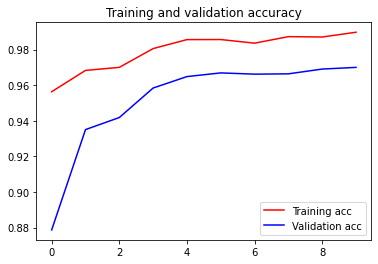

<Figure size 432x288 with 0 Axes>

In [4]:
import json
import matplotlib.pyplot as plt

f = open("train_log/svhn-dorefa-6,6,6/stats_def_first&last_avg_pooling_666.json","r")

data = json.load(f)
accuracy = []
val_accuracy = []
for ob in data:
  accuracy.append(ob["accuracy"])
  val_accuracy.append(ob["val_accuracy"])

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [5]:
from tabulate import tabulate
import matplotlib.pyplot as plt

ep = [i+1 for i in epochs]
table_acc = {"Epochs" : ep, "Accuracy":accuracy}
table_val_acc = {"Epochs" : ep, "Accuracy":val_accuracy}

print("ACCURACY\n")
print(tabulate(table_acc, headers='keys', tablefmt='fancy_grid'))
print("\nVALIDATION ACCURACY\n")
print(tabulate(table_val_acc, headers='keys', tablefmt='fancy_grid'))

ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.956295 │
├──────────┼────────────┤
│        2 │   0.96827  │
├──────────┼────────────┤
│        3 │   0.96998  │
├──────────┼────────────┤
│        4 │   0.980527 │
├──────────┼────────────┤
│        5 │   0.985578 │
├──────────┼────────────┤
│        6 │   0.98561  │
├──────────┼────────────┤
│        7 │   0.983571 │
├──────────┼────────────┤
│        8 │   0.987238 │
├──────────┼────────────┤
│        9 │   0.987033 │
├──────────┼────────────┤
│       10 │   0.989712 │
╘══════════╧════════════╛

VALIDATION ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.878676 │
├──────────┼────────────┤
│        2 │   0.935023 │
├──────────┼────────────┤
│        3 │   0.941802 │
├──────────┼────────────┤
│        4 │   0.958372 │
├──────────┼────────────┤
│        5 │   0.964805 │
├──────────┼────────────┤
│        6 │   0.966873 │
├─────